In [28]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
import dash
from dash import dcc
from dash import html

In [29]:
data_path = os.path.join(os.getcwd(), "data")
seller_items_path = os.path.join(data_path, "input", "seller_items")

In [30]:
# Lista para armazenar os dados
data = []

# Percorrer todos os arquivos no diretório
for filename in os.listdir(seller_items_path):
    if filename.endswith("_items.json"):  # Garantir que são arquivos de sellers
        file_path = os.path.join(seller_items_path, filename)

        # Abrir e ler o arquivo linha por linha
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
                try:
                    item_data = json.loads(line)  # Converter JSON para dicionário
                    data.append(item_data)
                except json.JSONDecodeError as e:
                    print(f"Erro ao ler {filename}: {e}")

In [31]:
# Criar DataFrame do pandas
df = pd.DataFrame(data)
data=None
df["available_amount"] = df["price"] * df["available_qty"]
df["original_price"] = df["original_price"].fillna(df["price"])
# Exibir as primeiras linhas
display(df.head())

,seller_id,category_id,price,original_price,discount,available_qty,cataloged,free_shipping,condition,installments,buying_mode,city,state,has_gtin,num_attributes,available_amount
0,1001057832,MLA14407,169999.00,169999.00,0.00,1,1,1,new,6,buy_it_now,Olivos,Buenos Aires,1,6,169999.00
1,1001057832,MLA14407,189999.00,189999.00,0.00,1,1,1,new,6,buy_it_now,Olivos,Buenos Aires,1,8,189999.00
2,1001057832,MLA430383,99900.00,99900.00,0.00,1,1,1,new,6,buy_it_now,Olivos,Buenos Aires,1,9,99900.00
3,1001057832,MLA407557,129999.00,129999.00,0.00,1,1,1,new,3,buy_it_now,Olivos,Buenos Aires,1,7,129999.00
4,1001057832,MLA91758,167999.00,167999.00,0.00,1,1,1,new,3,buy_it_now,Olivos,Buenos Aires,1,9,167999.00


In [32]:
import numpy as np
import scipy.stats as stats

df_grouped = df.groupby("seller_id").agg(
    {
        "category_id": [
            lambda x: list(set(x)),  # Unique categories
            lambda x: len(set(x)),  # Number of unique categories
            lambda x: (
                x.mode().iloc[0] if not x.mode().empty else None
            ),  # Most frequent category
            lambda x: (
                x.value_counts(normalize=True).max() if not x.empty else 0
            ),  # Dominant category ratio
        ],
        "price": [
            "count",
            "mean",
            lambda x: np.mean((x - np.mean(x)) ** 2),  # MSE
            lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode
            lambda x: np.percentile(x, 75)
            - np.percentile(x, 25),  # IQR (Interquartile Range)
            lambda x: (
                np.std(x) / np.mean(x) if np.mean(x) > 0 else 0
            ),  # Coefficient of Variation (CV)
        ],
        "original_price": ["mean", lambda x: np.mean((x - np.mean(x)) ** 2)],  # MSE
        "discount": ["mean", lambda x: np.mean((x - np.mean(x)) ** 2)],  # MSE
        "available_qty": ["sum", "mean", lambda x: np.mean((x - np.mean(x)) ** 2)],  # MSE
        "cataloged": "sum",
        "free_shipping": "sum",
        "condition": lambda x: (
            x.mode().iloc[0] if not x.mode().empty else None
        ),  # Most frequent condition
        "installments": ["mean", lambda x: np.mean((x - np.mean(x)) ** 2)],  # MSE
        "buying_mode": lambda x: (
            x.mode().iloc[0] if not x.mode().empty else None
        ),  # Most frequent buying mode
        "city": [
            lambda x: (
                x.mode().iloc[0] if not x.mode().empty else None
            ),  # Most frequent city
        ],
        "state": lambda x: (
            x.mode().iloc[0] if not x.mode().empty else None
        ),  # Most frequent state
        "has_gtin": "sum",
        "num_attributes": ["mean", lambda x: np.mean((x - np.mean(x)) ** 2), "median"],  # MSE
        "available_amount": ["mean", lambda x: np.mean((x - np.mean(x)) ** 2), "median"]  # MSE
    }
)

# Rename Columns
df_grouped.columns = [
    "unique_categories",
    "num_categories",
    "mode_category",
    "dominant_category_ratio",
    "price_count",
    "price_mean",
    "price_mse",
    "price_mode",
    "price_iqr",
    "price_cv",
    "original_price_mean",
    "original_price_mse",
    "discount_mean",
    "discount_mse",
    "available_qty_sum",
    "available_qty_mean",
    "available_qty_mse",
    "cataloged_sum",
    "free_shipping_sum",
    "condition_mode",
    "installments_mean",
    "installments_mse",
    "buying_mode_mode",
    "most_frequent_city",
    "most_frequent_state",
    "has_gtin_sum",
    "num_attributes_mean",
    "num_attributes_mse",
    "num_attributes_median",
    "available_amount_mean",
    "available_amount_mse",
    "available_amount_median",
]

df_grouped = df_grouped.reset_index()

df_grouped["total_offers"] = df.groupby("seller_id")["seller_id"].agg('count').values

# Compute proportions
df_grouped["proportion_cataloged"] = (
    df_grouped["cataloged_sum"] / df_grouped["total_offers"]
)
df_grouped["proportion_free_shipping"] = (
    df_grouped["free_shipping_sum"] / df_grouped["total_offers"]
)
df_grouped["proportion_has_gtin"] = (
    df_grouped["has_gtin_sum"] / df_grouped["total_offers"]
)

# Compute the count of "new" condition for each seller
df_grouped["condition_new_count"] = df.groupby("seller_id")["condition"].apply(
    lambda x: (x == "new").sum()  # Count how many "new" conditions
).values

# Compute the proportion of "new" condition
df_grouped["proportion_new"] = (
    df_grouped["condition_new_count"] / df_grouped["total_offers"]
).values

# Compute the count of "buy_it_now" buying mode for each seller
df_grouped["buying_mode_buy_it_now_count"] = df.groupby("seller_id")[
    "buying_mode"
].apply(
    lambda x: (x == "buy_it_now").sum()  # Count how many "buy_it_now" modes
).values

# Compute the proportion of "buy_it_now"
df_grouped["proportion_buy_it_now"] = (
    df_grouped["buying_mode_buy_it_now_count"] / df_grouped["total_offers"]
)

# Compute items per category
df_grouped["items_per_category"] = (
    df_grouped["total_offers"] / df_grouped["num_categories"]
)

# Compute frequency of each city in the dataset
city_counts = df["city"].value_counts(normalize=True).to_dict()

# Map city frequencies to df_grouped based on the most frequent city of each seller
df_grouped["city_frequency"] = df_grouped["most_frequent_city"].map(city_counts)

# Compute frequency of each city in the dataset
category_counts = df["category_id"].value_counts(normalize=True).to_dict()

# Map category frequencies to df_grouped based on the most frequencies city of each seller
df_grouped["category_frequency"] = df_grouped["mode_category"].map(category_counts)

# Count distinct cities per seller
df_grouped["distinct_cities_count"] = (
    df.groupby("seller_id")["city"].nunique().reset_index()["city"]
)

display(df_grouped.head())

,seller_id,unique_categories,num_categories,mode_category,dominant_category_ratio,price_count,price_mean,price_mse,price_mode,price_iqr,...,proportion_free_shipping,proportion_has_gtin,condition_new_count,proportion_new,buying_mode_buy_it_now_count,proportion_buy_it_now,items_per_category,city_frequency,category_frequency,distinct_cities_count
0,23143,"[MLA1055, MLA4773, MLA3697]",3,MLA1055,0.50,4,171762.50,13781206996.75,16399.00,203890.50,...,0.75,1.00,4,1.00,4,1.00,1.33,0.01,0.00,1
1,100471,"[MLA434737, MLA125136, MLA431810, MLA70387, ML...",19,MLA5338,0.22,78,12423.02,144106182.92,6999.00,9250.00,...,0.12,0.18,78,1.00,78,1.00,4.11,0.01,0.00,1
2,100972,[MLA8830],1,MLA8830,1.00,6,155833.33,4761805555.56,65000.00,92500.00,...,1.00,0.17,6,1.00,6,1.00,6.00,0.00,0.01,1
3,104859,"[MLA61249, MLA43677, MLA90322, MLA388868, MLA4...",26,MLA409392,0.18,82,265459.02,172512377322.67,84500.00,180475.00,...,0.79,0.07,82,1.00,82,1.00,3.15,0.01,0.00,1
4,105065,"[MLA40387, MLA79321, MLA7841, MLA18366, MLA112...",43,MLA1174,0.50,1000,12526.65,294842391.14,4499.00,9625.00,...,0.06,0.75,988,0.99,1000,1.00,23.26,0.01,0.02,1


In [33]:
df_fields = df_grouped[
    [
        "num_categories",
        "category_frequency",
        "dominant_category_ratio",
        "price_mean",
        "price_mse",
        "price_mode",
        "price_iqr",
        "price_cv",
        "original_price_mean",
        "original_price_mse",
        "discount_mean",
        "discount_mse",
        "available_qty_mean",
        "available_qty_mse",
        "proportion_cataloged",
        "proportion_free_shipping",
        "condition_mode",
        "proportion_new",
        "installments_mean",
        "installments_mse",
        "buying_mode_mode",
        "proportion_buy_it_now",
        "most_frequent_city",
        "distinct_cities_count",
        "proportion_has_gtin",
        "num_attributes_mean",
        "num_attributes_mse",
        "num_attributes_median",
        "available_amount_mean",
        "available_amount_mse",
        "available_amount_median",
        "total_offers",
    ]
]
display(df_fields.head())

,num_categories,category_frequency,dominant_category_ratio,price_mean,price_mse,price_mode,price_iqr,price_cv,original_price_mean,original_price_mse,...,most_frequent_city,distinct_cities_count,proportion_has_gtin,num_attributes_mean,num_attributes_mse,num_attributes_median,available_amount_mean,available_amount_mse,available_amount_median,total_offers
0,3,0.00,0.50,171762.50,13781206996.75,16399.00,203890.50,0.68,171762.50,13781206996.75,...,La Plata,1,1.00,8.75,1.69,9.00,171762.50,13781206996.75,190326.00,4
1,19,0.00,0.22,12423.02,144106182.92,6999.00,9250.00,0.97,12453.78,145727432.81,...,Almagro,1,0.18,5.17,4.37,4.00,14621.11,476907673.11,6999.00,78
2,1,0.01,1.00,155833.33,4761805555.56,65000.00,92500.00,0.44,155833.33,4761805555.56,...,Parque Avellaneda,1,0.17,6.50,1.58,6.00,155833.33,4761805555.56,157500.00,6
3,26,0.00,0.18,265459.02,172512377322.67,84500.00,180475.00,1.56,265459.02,172512377322.67,...,Martínez,1,0.07,4.32,4.53,4.00,265459.02,172512377322.67,114250.00,82
4,43,0.02,0.50,12526.65,294842391.14,4499.00,9625.00,1.37,12526.65,294842391.14,...,Villa Urquiza,1,0.75,2.67,2.75,2.00,33757.69,65446140920.32,7499.00,1000


In [34]:
# Function to check if a column is numeric
def is_numeric(col):
    return pd.api.types.is_numeric_dtype(col)


# Iterate through the columns and apply frequency encoding if not numeric
for column in df_fields.columns:
    if not is_numeric(df_fields[column]):
        # Apply frequency encoding to non-numeric columns
        freq_encoding = df_fields[column].value_counts(normalize=True).to_dict()
        df_fields.loc[:, column] = df_fields[column].map(
            freq_encoding
        )

display(df_fields.head())

,num_categories,category_frequency,dominant_category_ratio,price_mean,price_mse,price_mode,price_iqr,price_cv,original_price_mean,original_price_mse,...,most_frequent_city,distinct_cities_count,proportion_has_gtin,num_attributes_mean,num_attributes_mse,num_attributes_median,available_amount_mean,available_amount_mse,available_amount_median,total_offers
0,3,0.00,0.50,171762.50,13781206996.75,16399.00,203890.50,0.68,171762.50,13781206996.75,...,0.01,1,1.00,8.75,1.69,9.00,171762.50,13781206996.75,190326.00,4
1,19,0.00,0.22,12423.02,144106182.92,6999.00,9250.00,0.97,12453.78,145727432.81,...,0.01,1,0.18,5.17,4.37,4.00,14621.11,476907673.11,6999.00,78
2,1,0.01,1.00,155833.33,4761805555.56,65000.00,92500.00,0.44,155833.33,4761805555.56,...,0.00,1,0.17,6.50,1.58,6.00,155833.33,4761805555.56,157500.00,6
3,26,0.00,0.18,265459.02,172512377322.67,84500.00,180475.00,1.56,265459.02,172512377322.67,...,0.00,1,0.07,4.32,4.53,4.00,265459.02,172512377322.67,114250.00,82
4,43,0.02,0.50,12526.65,294842391.14,4499.00,9625.00,1.37,12526.65,294842391.14,...,0.01,1,0.75,2.67,2.75,2.00,33757.69,65446140920.32,7499.00,1000


/tmp/ipykernel_7314/339633621.py:4: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



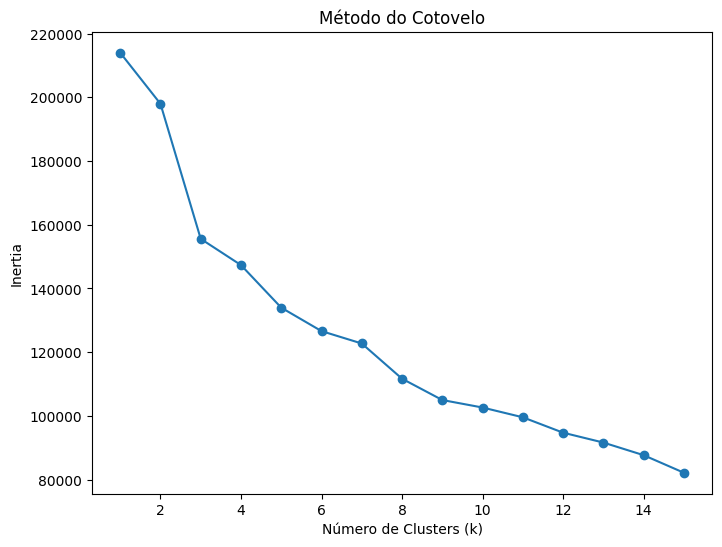

In [35]:
# 🔹 Passo 1: Selecionar as features relevantes
df_fields = df_fields.copy()  # Criar uma cópia para evitar avisos de mutação

df_fields = df_fields.fillna(0)

# 🔹 Passo 4: Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_fields)

# 🔹 Passo 5: Encontrar o número ideal de clusters (Método do Cotovelo)
inertia = []
K_range = range(1, 16)  # Testando de 1 a 10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 🔹 Passo 6: Plotar o Método do Cotovelo
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [36]:
from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df_fields["cluster"] = kmeans.fit_predict(X_scaled)
    try:
        sil_score = silhouette_score(X_scaled, df_fields["cluster"])
        print(f"Silhouette Score: {sil_score:.4f} for k={k}")
    except:
        pass

Silhouette Score: 0.4603 for k=2
Silhouette Score: 0.4629 for k=3
Silhouette Score: 0.1022 for k=4
Silhouette Score: 0.1259 for k=5
Silhouette Score: 0.1339 for k=6
Silhouette Score: 0.1157 for k=7
Silhouette Score: 0.1292 for k=8
Silhouette Score: 0.1426 for k=9
Silhouette Score: 0.1298 for k=10
Silhouette Score: 0.1340 for k=11
Silhouette Score: 0.1350 for k=12
Silhouette Score: 0.1379 for k=13
Silhouette Score: 0.1384 for k=14
Silhouette Score: 0.1483 for k=15


In [37]:
# Passo 7: Aplicar K-Means com k escolhido
kmeans = KMeans(n_clusters=9, random_state=42)
df_fields["cluster"] = kmeans.fit_predict(X_scaled)

# Passo 8: Visualizar os primeiros vendedores e seus clusters
df_fields.head()

,num_categories,category_frequency,dominant_category_ratio,price_mean,price_mse,price_mode,price_iqr,price_cv,original_price_mean,original_price_mse,...,distinct_cities_count,proportion_has_gtin,num_attributes_mean,num_attributes_mse,num_attributes_median,available_amount_mean,available_amount_mse,available_amount_median,total_offers,cluster
0,3,0.00,0.50,171762.50,13781206996.75,16399.00,203890.50,0.68,171762.50,13781206996.75,...,1,1.00,8.75,1.69,9.00,171762.50,13781206996.75,190326.00,4,6
1,19,0.00,0.22,12423.02,144106182.92,6999.00,9250.00,0.97,12453.78,145727432.81,...,1,0.18,5.17,4.37,4.00,14621.11,476907673.11,6999.00,78,0
2,1,0.01,1.00,155833.33,4761805555.56,65000.00,92500.00,0.44,155833.33,4761805555.56,...,1,0.17,6.50,1.58,6.00,155833.33,4761805555.56,157500.00,6,4
3,26,0.00,0.18,265459.02,172512377322.67,84500.00,180475.00,1.56,265459.02,172512377322.67,...,1,0.07,4.32,4.53,4.00,265459.02,172512377322.67,114250.00,82,4
4,43,0.02,0.50,12526.65,294842391.14,4499.00,9625.00,1.37,12526.65,294842391.14,...,1,0.75,2.67,2.75,2.00,33757.69,65446140920.32,7499.00,1000,0


In [38]:
# 🔹 Passo 1: Reduzir para 3 dimensões com PCA
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# 🔹 Passo 2: Normalizar os componentes principais
scaler_pca = StandardScaler()
X_pca_3d_normalized = scaler_pca.fit_transform(X_pca_3d)

# 🔹 Passo 3: Criar gráfico 3D com Plotly
df_pca_normalized = pd.DataFrame(X_pca_3d_normalized, columns=["PC1", "PC2", "PC3"])
df_pca_normalized["cluster"] = df_fields["cluster"]

# # Criar o gráfico interativo
# fig = px.scatter_3d(
#     df_pca_normalized,
#     x="PC1",
#     y="PC2",
#     z="PC3",
#     color="cluster",
#     title="Clusters de Vendedores (PCA 3D - Normalizado)",
#     labels={
#         "PC1": "Componente Principal 1 (Normalizado)",
#         "PC2": "Componente Principal 2 (Normalizado)",
#         "PC3": "Componente Principal 3 (Normalizado)",
#     },
#     color_continuous_scale="viridis",
# )

# Exibir o gráfico
#fig.show()

In [39]:
# Assuming X_pca_3d_normalized is your PCA-transformed data
# Get the indices of the top 3 highest values from each PCA column (PCA1, PCA2, PCA3)
top_indices_pca1 = np.argsort(X_pca_3d_normalized[:, 0])[::-1][
    :5
]  # Top 3 indices for PCA1
top_indices_pca2 = np.argsort(X_pca_3d_normalized[:, 1])[::-1][
    :5
]  # Top 3 indices for PCA2
top_indices_pca3 = np.argsort(X_pca_3d_normalized[:, 2])[::-1][
    :5
]  # Top 3 indices for PCA3

# Combine all top indices (ensure uniqueness)
top_indices = np.unique(
    np.concatenate([top_indices_pca1, top_indices_pca2, top_indices_pca3])
)

# Remove outliers (top 3 highest values for each PCA column) from df_fields
df_fields = df_fields.drop(top_indices).reset_index(drop=True)

In [40]:
display(df_fields.iloc[top_indices])

,num_categories,category_frequency,dominant_category_ratio,price_mean,price_mse,price_mode,price_iqr,price_cv,original_price_mean,original_price_mse,...,distinct_cities_count,proportion_has_gtin,num_attributes_mean,num_attributes_mse,num_attributes_median,available_amount_mean,available_amount_mse,available_amount_median,total_offers,cluster
45,309,0.00,0.04,28896.88,1092558448.73,3640.00,23789.51,1.14,38416.92,1808090745.83,...,1,0.50,6.08,4.62,6.00,1588145.67,9798218817996.74,67925.38,1000,8
107,110,0.00,0.07,9930.32,107620229.39,8500.00,8255.00,1.04,9930.32,107620229.39,...,1,0.49,5.76,4.16,5.00,9930.32,107620229.39,6400.00,256,0
131,31,0.00,0.48,34652.65,1109683355.04,7368.00,28361.00,0.96,48088.91,2303854397.92,...,1,0.08,5.52,2.58,5.00,640040.25,2222091296561.80,42423.30,519,8
1012,7,0.01,0.85,71028.98,2901904079.90,49990.00,15000.00,0.76,71028.98,2901904079.90,...,1,0.91,5.83,2.30,6.00,71028.98,2901904079.90,49990.00,693,6
1101,4,0.00,0.50,302525.00,130452589375.00,15600.00,486900.00,1.19,302525.00,130452589375.00,...,1,0.00,3.50,3.00,3.00,302525.00,130452589375.00,139000.00,8,5
2112,37,0.00,0.20,211561.06,27368050863.38,91999.00,141744.70,0.78,218197.64,27953144981.17,...,1,0.52,6.64,3.05,7.00,51497036.35,47748018934689784.00,189999.01,952,1
2223,1,0.00,1.00,11733.33,42205555.56,5000.00,4900.00,0.55,11733.33,42205555.56,...,1,0.00,7.67,0.56,8.00,11733.33,42205555.56,9950.00,6,4
2387,83,0.00,0.13,20272.37,1794564177.67,8020.00,12054.00,2.09,20272.37,1794564177.67,...,1,0.03,5.34,3.59,5.00,421532.18,1941886816152.82,20827.00,1000,1
2589,26,0.00,0.28,265843.91,255901281936.41,270890.00,213680.29,1.90,278140.07,300760619439.48,...,1,0.13,4.35,1.35,4.00,12880293.60,7064221070575487.00,320170.00,300,4
5175,34,0.00,0.74,40755.79,10814315518.25,4999.00,20000.00,2.55,41479.24,11096556195.48,...,1,0.82,4.49,2.88,4.00,847859.34,6153841069177.18,27900.00,413,0


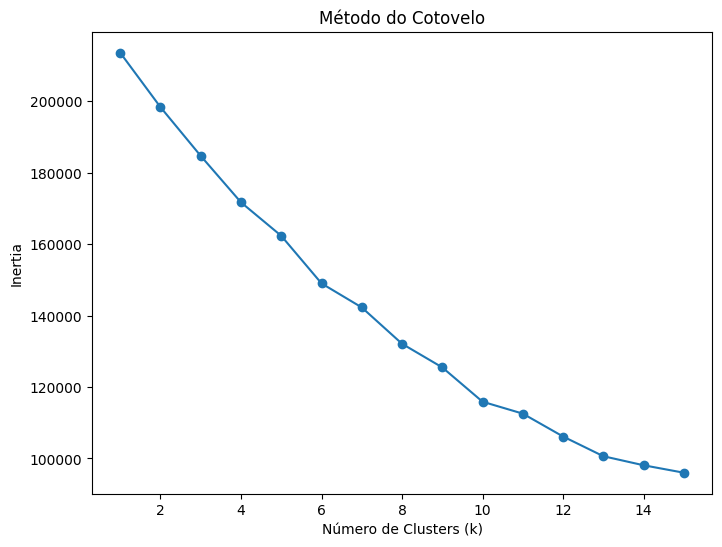

In [41]:
X_scaled = scaler.fit_transform(df_fields.drop("cluster", axis=1))

# 🔹 Passo 5: Encontrar o número ideal de clusters (Método do Cotovelo)
inertia = []
K_range = range(1, 16)  # Testando de 1 a 10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 🔹 Passo 6: Plotar o Método do Cotovelo
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [42]:
from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df_fields["cluster"] = kmeans.fit_predict(X_scaled)
    try:
        sil_score = silhouette_score(X_scaled, df_fields["cluster"])
        print(f"Silhouette Score: {sil_score:.4f} for k={k}")
    except:
        pass

Silhouette Score: 0.1077 for k=2
Silhouette Score: 0.1110 for k=3
Silhouette Score: 0.1106 for k=4
Silhouette Score: 0.0972 for k=5
Silhouette Score: 0.1194 for k=6
Silhouette Score: 0.1246 for k=7
Silhouette Score: 0.1279 for k=8
Silhouette Score: 0.1342 for k=9
Silhouette Score: 0.1179 for k=10
Silhouette Score: 0.1205 for k=11
Silhouette Score: 0.1358 for k=12
Silhouette Score: 0.1453 for k=13
Silhouette Score: 0.1459 for k=14
Silhouette Score: 0.1476 for k=15


In [43]:
# 🔹 Passo 7: Aplicar K-Means com k escolhido (exemplo: k=4)
kmeans = KMeans(n_clusters=7, random_state=42)
df_fields["cluster"] = kmeans.fit_predict(X_scaled)

# 🔹 Passo 8: Visualizar os primeiros vendedores e seus clusters
df_fields.head()

,num_categories,category_frequency,dominant_category_ratio,price_mean,price_mse,price_mode,price_iqr,price_cv,original_price_mean,original_price_mse,...,distinct_cities_count,proportion_has_gtin,num_attributes_mean,num_attributes_mse,num_attributes_median,available_amount_mean,available_amount_mse,available_amount_median,total_offers,cluster
0,3,0.00,0.50,171762.50,13781206996.75,16399.00,203890.50,0.68,171762.50,13781206996.75,...,1,1.00,8.75,1.69,9.00,171762.50,13781206996.75,190326.00,4,4
1,19,0.00,0.22,12423.02,144106182.92,6999.00,9250.00,0.97,12453.78,145727432.81,...,1,0.18,5.17,4.37,4.00,14621.11,476907673.11,6999.00,78,1
2,1,0.01,1.00,155833.33,4761805555.56,65000.00,92500.00,0.44,155833.33,4761805555.56,...,1,0.17,6.50,1.58,6.00,155833.33,4761805555.56,157500.00,6,1
3,26,0.00,0.18,265459.02,172512377322.67,84500.00,180475.00,1.56,265459.02,172512377322.67,...,1,0.07,4.32,4.53,4.00,265459.02,172512377322.67,114250.00,82,1
4,43,0.02,0.50,12526.65,294842391.14,4499.00,9625.00,1.37,12526.65,294842391.14,...,1,0.75,2.67,2.75,2.00,33757.69,65446140920.32,7499.00,1000,2


In [44]:
# 🔹 Passo 1: Reduzir para 3 dimensões com PCA
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# 🔹 Passo 2: Normalizar os componentes principais
scaler_pca = StandardScaler()
X_pca_3d_normalized = scaler_pca.fit_transform(X_pca_3d)

# 🔹 Passo 3: Criar gráfico 3D com Plotly
df_pca_normalized = pd.DataFrame(X_pca_3d_normalized, columns=["PC1", "PC2", "PC3"])
df_pca_normalized["cluster"] = df_fields["cluster"]

# # Criar o gráfico interativo
# fig = px.scatter_3d(
#     df_pca_normalized,
#     x="PC1",
#     y="PC2",
#     z="PC3",
#     color="cluster",
#     title="Clusters de Vendedores (PCA 3D - Normalizado)",
#     labels={
#         "PC1": "Componente Principal 1 (Normalizado)",
#         "PC2": "Componente Principal 2 (Normalizado)",
#         "PC3": "Componente Principal 3 (Normalizado)",
#     },
#     color_continuous_scale="viridis",
# )

# Exibir o gráfico
#fig.show()

In [45]:
# # Calcular os min e max para os pares de componentes PCA (considerando todos os clusters)
# pca1_min, pca1_max = df_pca_normalized["PC1"].min(), df_pca_normalized["PC1"].max()
# pca2_min, pca2_max = df_pca_normalized["PC2"].min(), df_pca_normalized["PC2"].max()
# pca3_min, pca3_max = df_pca_normalized["PC3"].min(), df_pca_normalized["PC3"].max()

# # Definir os intervalos globais para cada par de PCA
# x_range_12 = [min(pca1_min, pca2_min), max(pca1_max, pca2_max)]  # PCA1 vs PCA2
# y_range_12 = [min(pca1_min, pca2_min), max(pca1_max, pca2_max)]

# x_range_23 = [min(pca2_min, pca3_min), max(pca2_max, pca3_max)]  # PCA2 vs PCA3
# y_range_23 = [min(pca2_min, pca3_min), max(pca2_max, pca3_max)]

# x_range_13 = [min(pca1_min, pca3_min), max(pca1_max, pca3_max)]  # PCA1 vs PCA3
# y_range_13 = [min(pca1_min, pca3_min), max(pca1_max, pca3_max)]

# # Criar o layout para os subgráficos (3 subgráficos por cluster)
# fig = make_subplots(
#     rows=len(set(df_pca_normalized["cluster"])),
#     cols=3,  # Uma linha por cluster, 3 colunas para cada par de componentes PCA
#     subplot_titles=["PCA1 vs PCA2", "PCA2 vs PCA3", "PCA1 vs PCA3"],
#     specs=[
#         [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]
#         for _ in range(len(set(df_pca_normalized["cluster"])))
#     ],
# )

# # Loop para cada cluster e adicionar os gráficos
# for i, cluster in enumerate(set(df_pca_normalized["cluster"])):
#     cluster_data = df_pca_normalized[df_pca_normalized["cluster"] == cluster]

#     # PCA1 vs PCA2 plot
#     scatter1 = go.Scatter(
#         x=cluster_data["PC1"],
#         y=cluster_data["PC2"],
#         mode="markers",
#         marker=dict(color=cluster_data["cluster"], colorscale="viridis"),
#         name=f"Cluster {cluster} (PCA1 vs PCA2)",
#     )
#     fig.add_trace(scatter1, row=i + 1, col=1)

#     # PCA2 vs PCA3 plot
#     scatter2 = go.Scatter(
#         x=cluster_data["PC2"],
#         y=cluster_data["PC3"],
#         mode="markers",
#         marker=dict(color=cluster_data["cluster"], colorscale="viridis"),
#         name=f"Cluster {cluster} (PCA2 vs PCA3)",
#     )
#     fig.add_trace(scatter2, row=i + 1, col=2)

#     # PCA1 vs PCA3 plot
#     scatter3 = go.Scatter(
#         x=cluster_data["PC1"],
#         y=cluster_data["PC3"],
#         mode="markers",
#         marker=dict(color=cluster_data["cluster"], colorscale="viridis"),
#         name=f"Cluster {cluster} (PCA1 vs PCA3)",
#     )
#     fig.add_trace(scatter3, row=i + 1, col=3)

# # Definir os intervalos para todos os subgráficos de forma que os eixos sejam fixos para cada tipo de comparação
# fig.update_layout(
#     title="Clusters de Vendedores (PCA 2D Comparisons)",
#     height=3000,
#     width=3000
# )

# # Exibir a figura
# fig.show()

In [46]:
# Obter a matriz de cargas (loadings)
pca_components = pd.DataFrame(
    pca.components_,  # Coeficientes do PCA
    columns=df_fields.drop(columns='cluster').columns,  # Nome das variáveis originais
    index=[f"PC{i+1}" for i in range(pca.n_components_)],  # Nome dos componentes
)

# Exibir a matriz de cargas dos 3 primeiros PCs
pca_components.T.sort_values(by="PC1", ascending=False)

,PC1,PC2,PC3
original_price_mean,0.44,-0.24,-0.05
price_mean,0.44,-0.24,-0.06
original_price_mse,0.34,-0.24,-0.07
price_mse,0.34,-0.24,-0.07
price_iqr,0.25,-0.07,-0.01
proportion_free_shipping,0.20,0.13,0.05
proportion_cataloged,0.19,0.26,0.02
num_attributes_mean,0.18,0.35,0.11
num_attributes_median,0.17,0.34,0.10
price_mode,0.17,-0.07,-0.01


In [47]:
# # Thresholds
# upper_threshold = 0.2
# lower_threshold = -0.1

# relevant_fields = {}

# # Filtrar variáveis com pesos maiores que 0.2 ou menores que -0.1
# for pc in pca_components.index:
#     relevant_fields[pc] = pca_components.T[pc][
#         (pca_components.T[pc] >= upper_threshold)
#         | (pca_components.T[pc] <= lower_threshold)
#     ]

# # Criar o gráfico de barras interativo para os 3 primeiros componentes principais (PC1, PC2, PC3)
# fig = make_subplots(
#     rows=1,
#     cols=3,  # 1 linha com 3 colunas
#     subplot_titles=["Pesos do PCA1", "Pesos do PCA2", "Pesos do PCA3"],
# )

# # Gráfico para PC1
# fig.add_trace(
#     go.Bar(
#         x=relevant_fields["PC1"].index,  # Variáveis relevantes
#         y=relevant_fields["PC1"].values,  # Pesos relevantes
#         name="PC1",
#         marker_color="royalblue",
#     ),
#     row=1,
#     col=1,
# )

# # Gráfico para PC2
# fig.add_trace(
#     go.Bar(
#         x=relevant_fields["PC2"].index,  # Variáveis relevantes
#         y=relevant_fields["PC2"].values,  # Pesos relevantes
#         name="PC2",
#         marker_color="orange",
#     ),
#     row=1,
#     col=2,
# )

# # Gráfico para PC3
# fig.add_trace(
#     go.Bar(
#         x=relevant_fields["PC3"].index,  # Variáveis relevantes
#         y=relevant_fields["PC3"].values,  # Pesos relevantes
#         name="PC3",
#         marker_color="green",
#     ),
#     row=1,
#     col=3,
# )

# # Atualizar o layout para que fique mais legível
# fig.update_layout(
#     title="Pesos Relevantes dos Componentes Principais (PCA)",
#     height=600,
#     showlegend=False,
#     xaxis=dict(tickangle=90),  # Rotaciona os rótulos do eixo X
#     xaxis2=dict(tickangle=90),  # Rotaciona os rótulos do eixo X para o segundo gráfico
#     xaxis3=dict(tickangle=90),  # Rotaciona os rótulos do eixo X para o terceiro gráfico
#     barmode="group",  # Organiza as barras em grupos
# )

# # Exibir o gráfico interativo
# fig.show()

In [48]:
# # Assuming df_fields is your DataFrame and has a 'cluster' column
# X = df_fields.drop(columns="cluster").values  # Features
# y = df_fields["cluster"].values  # Labels (or clusters)

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Perform PCA with 2 components for visualization
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)


# # Create a Plotly biplot
# def plot_biplot(score, coeff, labels=None):
#     xs = score[:, 0]
#     ys = score[:, 1]
#     n = coeff.shape[0]

#     # Create the figure
#     fig = go.Figure()

#     # Scatter plot for the PCA scores (data points)
#     fig.add_trace(
#         go.Scatter(
#             x=xs,
#             y=ys,
#             mode="markers",
#             marker=dict(
#                 color=y, colorscale="Viridis", showscale=True
#             ),  # Color by clusters
#             name="PCA points",
#         )
#     )

#     # Adding arrows for each feature (vectors)
#     for i in range(n):
#         fig.add_trace(
#             go.Scatter(
#                 x=[0, coeff[i, 0]],  # Start from the origin
#                 y=[0, coeff[i, 1]],  # End at the component direction
#                 mode="lines+text",
#                 line=dict(color="red", width=2),
#                 text=[
#                     None,
#                     labels[i] if labels is not None else f"Var{i + 1}",
#                 ],  # Feature label
#                 textposition="top center",
#                 name=f"Feature {labels[i]}" if labels is not None else f"Var{i + 1}",
#             )
#         )

#     # Layout settings
#     fig.update_layout(
#         title="PCA Biplot - First Two Principal Components",
#         xaxis_title="PC1",
#         yaxis_title="PC2",
#         showlegend=True,
#         template="plotly_dark",  # Dark theme (optional)
#     )

#     # Show the plot
#     #fig.show()


# # Call the plotting function
# plot_biplot(
#     X_pca[:, 0:2], pca.components_.T, labels=df_fields.columns
# )  # Feature names as labels

In [49]:
# # Assuming df_fields is your DataFrame and has a 'cluster' column
# X = df_fields.drop(columns="cluster").values  # Features
# y = df_fields["cluster"].values  # Labels (or clusters)

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Perform PCA with 2 components for visualization
# pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X_scaled)


# # Create a Plotly biplot
# def plot_biplot(score, coeff, labels=None):
#     xs = score[:, 0]
#     ys = score[:, 1]
#     n = coeff.shape[0]

#     # Create the figure
#     fig = go.Figure()

#     # Scatter plot for the PCA scores (data points)
#     fig.add_trace(
#         go.Scatter(
#             x=xs,
#             y=ys,
#             mode="markers",
#             marker=dict(
#                 color=y, colorscale="Viridis", showscale=True
#             ),  # Color by clusters
#             name="PCA points",
#         )
#     )

#     # Adding arrows for each feature (vectors)
#     for i in range(n):
#         fig.add_trace(
#             go.Scatter(
#                 x=[0, coeff[i, 0]],  # Start from the origin
#                 y=[0, coeff[i, 1]],  # End at the component direction
#                 mode="lines+text",
#                 line=dict(color="red", width=2),
#                 text=[
#                     None,
#                     labels[i] if labels is not None else f"Var{i + 1}",
#                 ],  # Feature label
#                 textposition="top center",
#                 name=f"Feature {labels[i]}" if labels is not None else f"Var{i + 1}",
#             )
#         )

#     # Layout settings
#     fig.update_layout(
#         title="PCA Biplot - First Two Principal Components",
#         xaxis_title="PC2",
#         yaxis_title="PC3",
#         showlegend=True,
#         template="plotly_dark",  # Dark theme (optional)
#     )

#     # Show the plot
#     #fig.show()


# # Call the plotting function
# plot_biplot(
#     X_pca[:, 1:3], pca.components_.T, labels=df_fields.columns
# )  # Feature names as labels

In [50]:
df_cluster_summary = df_fields.groupby("cluster").mean()
# # Variáveis numéricas para gerar boxplots
# numeric_cols = df_cluster_summary.columns

# # Gerar boxplots para cada variável numérica usando facet_col
# for col in numeric_cols:
#     fig = px.box(
#         df_fields,
#         x="cluster",  # Eixo X representando os clusters
#         y=col,  # Variável numérica
#         title=f"Distribuição de {col} por Cluster",
#         labels={"cluster": "Cluster", col: f"{col} Value"},  # Rótulos dos eixos
#         color="cluster",  # Colorir os boxplots por cluster
#         boxmode="group",  # Organizar os boxplots em grupos
#     )

#     # Exibir o gráfico interativo
#     fig.show()

In [51]:
pd.set_option("display.float_format", "{:.2f}".format)
df_cluster_summary_r = df_cluster_summary.reset_index()
df_cluster_summary_tr = df_cluster_summary_r.T.drop("cluster", axis = 0)
df_cluster_summary_tr

,0,1,2,3,4,5,6
num_categories,22.27,18.38,112.18,9.67,16.64,33.63,45.66
category_frequency,0.00,0.00,0.00,0.00,0.00,0.01,0.00
dominant_category_ratio,0.43,0.51,0.15,0.55,0.48,0.54,0.30
price_mean,8624153.66,80087.05,124152.59,426568.37,175631.06,142835.03,153987.91
price_mse,3734141166694118.00,103313465550.28,3264716654538.34,104764979875.94,283705344820.60,343421211495.21,153211491963.96
price_mode,1228691.73,38125.73,41418.55,287217.33,102622.50,97895.21,95379.71
price_iqr,3408465.41,57640.40,98866.95,149144.00,131915.28,73391.67,140607.98
price_cv,6.28,0.97,1.96,0.94,0.88,1.14,1.24
original_price_mean,8625140.52,81627.35,127799.89,449019.04,179950.17,142847.62,202043.35
original_price_mse,3734131658824979.50,104425079045.98,3376523761225.55,108474162588.10,287892081318.21,343424111281.23,255876641769.43


In [52]:
# df_heatmap = df_cluster_summary_tr
# # Create subplots for each feature (row)
# fig = make_subplots(
#     rows=len(df_heatmap.index),
#     cols=1,
#     shared_xaxes=True,
#     vertical_spacing=0.02,
#     subplot_titles=[],  # Row titles will be the feature names
# )

# # For each row (feature), add a heatmap with its own color scale
# for i, feature in enumerate(df_heatmap.index):
#     fig.add_trace(
#         go.Heatmap(
#             z=[df_heatmap.loc[feature].values],  # Select values for this row
#             x=df_heatmap.columns,  # Cluster labels (columns)
#             y=[feature],  # Feature label (row)
#             colorscale="YlGnBu",  # Choose a color scale
#             colorbar=dict(title="Feature Value"),
#             showscale=True,  # Display the color scale for each row
#             zmin=df_heatmap.loc[feature].min(),  # Set color scale minimum for this row
#             zmax=df_heatmap.loc[feature].max(),  # Set color scale maximum for this row
#         ),
#         row=i + 1,
#         col=1,  # Place the heatmap in the corresponding subplot row
#     )

# # Update layout for better presentation
# fig.update_layout(
#     height=1500,  # Adjust height as needed
#     width=1500,  # Adjust width as needed
#     showlegend=False,
# )

# fig.update_xaxes(
#     title_text="Clusters",  # X-axis titl
#     row=len(df_heatmap.index),  # Apply title to the last row
#     col=1,
# )

# fig.update_yaxes(
#     title_text="Features",  # X-axis title
#     row=len(df_heatmap.index) // 2,  # Apply title to the last row
#     col=1,
# )

# # Show plot
# fig.show()